In [1]:
import pandas as pd
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt

In [14]:
zeroyields = pd.read_excel('Zero yields.xlsx')
zeroyields = zeroyields.drop(0)
zeroyields = zeroyields.rename(columns={'Unnamed: 0': 'Date'})
zeroyields['Date'] = pd.to_datetime(zeroyields['Date'])
zeroyields.set_index('Date', inplace=True)
zeroyields = zeroyields.astype(float)

In [3]:
zeroyields

,0.25,1,2,3,4,5,6,7,8,9,10
Date,,,,,,,,,,,
1961-06-30,0.023232,0.028967,0.032685,0.034938,0.036289,0.037122,0.037661,0.038033,0.038305,0.038514,0.038676
1961-07-31,0.022338,0.027608,0.032216,0.035024,0.036767,0.037894,0.038663,0.039221,0.039646,0.039983,0.040253
1961-08-31,0.023829,0.029823,0.033877,0.036375,0.03789,0.03883,0.039441,0.039861,0.040167,0.040399,0.040579
1961-09-29,0.022735,0.02922,0.033166,0.035365,0.036645,0.037435,0.03796,0.038336,0.038624,0.038852,0.039037
1961-10-31,0.022934,0.028752,0.032311,0.0346,0.036081,0.037075,0.037778,0.038306,0.038721,0.039058,0.039334
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,0.052158,0.052848,0.048542,0.045014,0.042661,0.041222,0.040396,0.039957,0.039756,0.039694,0.039711
2023-08-31,0.052652,0.052717,0.048227,0.045067,0.043087,0.041925,0.041285,0.040966,0.04084,0.040827,0.040874
2023-09-29,0.052849,0.053619,0.050147,0.047661,0.046282,0.04568,0.045554,0.0457,0.04599,0.046345,0.046718


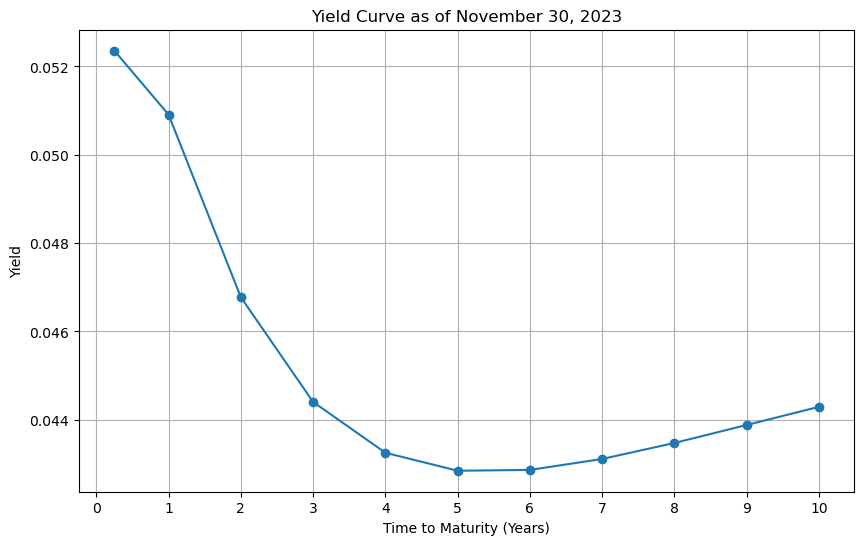

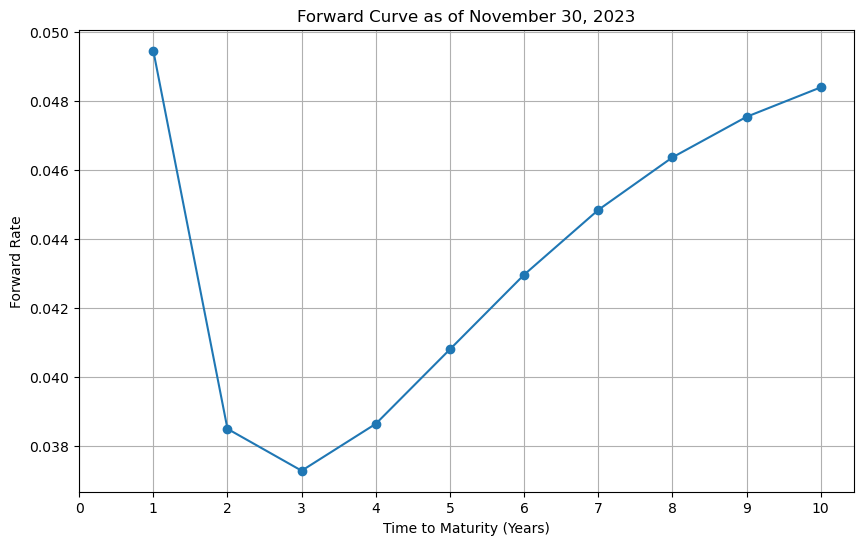

In [49]:

# Extract yields for November 30, 2023
nov_30_2023_yields = zeroyields.loc['2023-11-30']

# Plot the yield curve
plt.figure(figsize=(10, 6))
plt.plot(nov_30_2023_yields.index, nov_30_2023_yields.values, marker='o', linestyle='-')
plt.title('Yield Curve as of November 30, 2023')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Yield')
plt.grid(True)
plt.xticks(np.arange(0, 11, step=1))  # Assuming you want ticks for every year
plt.show()

# Calculate forward rates from the zero rates
# Forward rate from time t1 to t2 is given by f(t1, t2) = (R_t2 * t2 - R_t1 * t1) / (t2 - t1)
# forward_rates = [(nov_30_2023_yields[i] * (i+1) - nov_30_2023_yields[i-1] * i) /1 for i in range(1, len(nov_30_2023_yields))]
forward_rates = [(nov_30_2023_yields[i] * (i+1) - nov_30_2023_yields[i-1] * i) / (i+1 - i) for i in range(1, len(nov_30_2023_yields))]

# Plot the forward curve
plt.figure(figsize=(10, 6))
plt.plot(nov_30_2023_yields.index[1:], forward_rates, marker='o', linestyle='-')
plt.title('Forward Curve as of November 30, 2023')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Forward Rate')
plt.grid(True)
plt.xticks(np.arange(0, 11, step=1))  # Assuming you want ticks for every year
plt.show()

In [5]:
actual_yields = nov_30_2023_yields.values[1:]
short_rate = nov_30_2023_yields[0]
zero_yields = actual_yields[1:] 

In [6]:
expected_yields = []
for index, maturity in enumerate(forward_rates):
    if index == 0:
        expected_yield = ((forward_rates[index] - short_rate) / 0.75) + zero_yields[index]
    else:
        expected_yield = ((forward_rates[index] - short_rate) / index) + actual_yields[index]
    expected_yields.append(expected_yield)

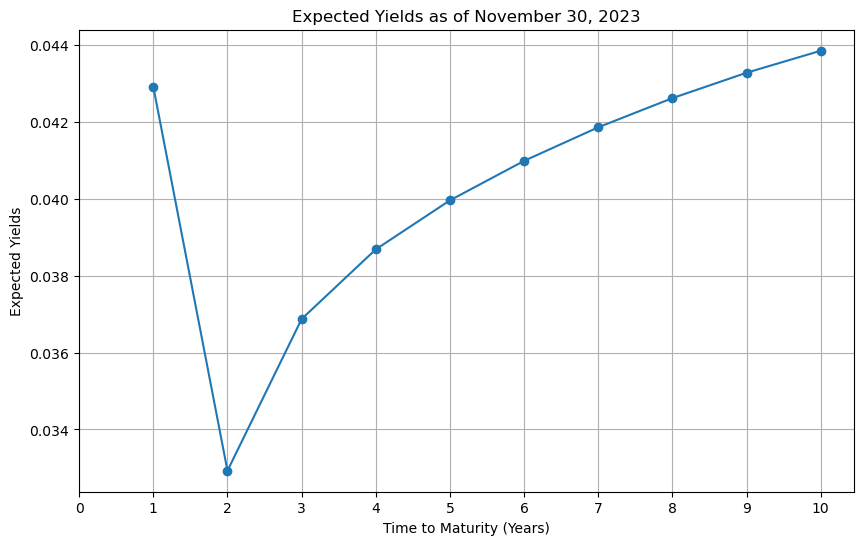

In [7]:
# Plot the forward curve
plt.figure(figsize=(10, 6))
plt.plot(nov_30_2023_yields.index[1:], expected_yields, marker='o', linestyle='-')
plt.title('Expected Yields as of November 30, 2023')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Expected Yields')
plt.grid(True)
plt.xticks(np.arange(0, 11, step=1))  # Assuming you want ticks for every year
plt.show()

In [8]:
zeroyields.columns

Index([0.25, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='object')

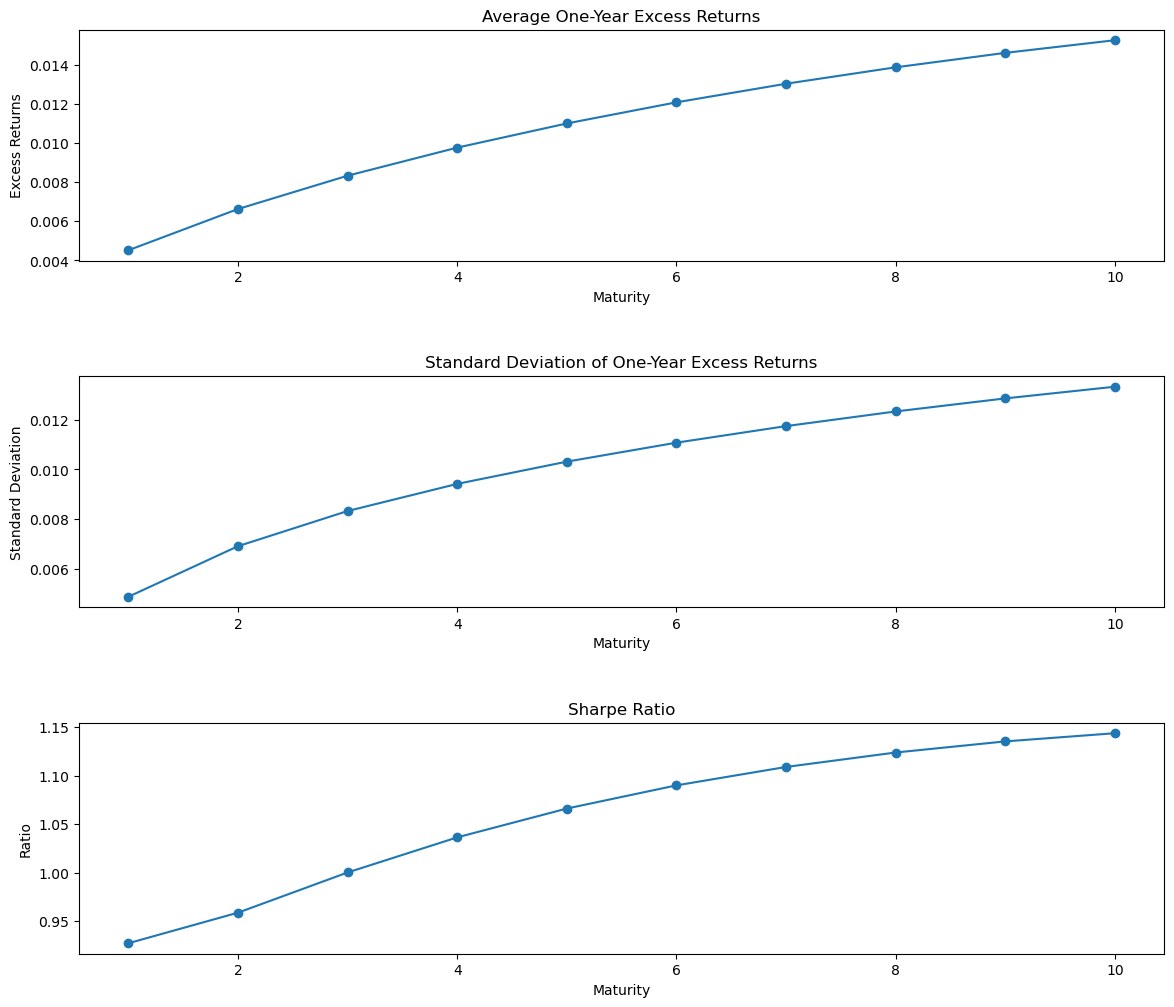

In [9]:
# Short rate is the shortest maturity rate 
short_rate = zeroyields[0.25]

# Excess return calculation
excess_returns = zeroyields.subtract(short_rate, axis=0)
excess_returns_mean = excess_returns.mean()
excess_returns_std = excess_returns.std()
maturities = zeroyields.columns
sharpe_ratio = excess_returns_mean / excess_returns_std

plt.figure(figsize=(14, 12))

plt.subplot(3, 1, 1)
plt.plot(maturities[1:], excess_returns_mean[1:], marker='o')
plt.title('Average One-Year Excess Returns')
plt.xlabel('Maturity')
plt.ylabel('Excess Returns')

plt.subplot(3, 1, 2)
plt.plot(maturities[1:], excess_returns_std[1:], marker='o')
plt.title('Standard Deviation of One-Year Excess Returns')
plt.xlabel('Maturity')
plt.ylabel('Standard Deviation')

plt.subplot(3, 1, 3)
plt.plot(maturities[1:], sharpe_ratio[1:], marker='o')
plt.title('Sharpe Ratio')
plt.xlabel('Maturity')
plt.ylabel('Ratio')

plt.subplots_adjust(hspace=0.5)  # Adjust vertical spacing

plt.show()


In [65]:
forward_rates_df = pd.DataFrame(index=zeroyields.index, columns=zeroyields.columns)

for row in range(len(zeroyields)):
    for column in range(1, len(zeroyields.columns)):
        forward_rates_df.iloc[row, column] = (zeroyields.iloc[row, column] * (column + 1) - zeroyields.iloc[row, column - 1] * column) / (column + 1 - column)

forward_rates_df = forward_rates_df.iloc[:, 1:]
zero_yields_noshort = zeroyields.iloc[:,1:]
zero_forward_spreads  = zero_yields_noshort - forward_rates_df

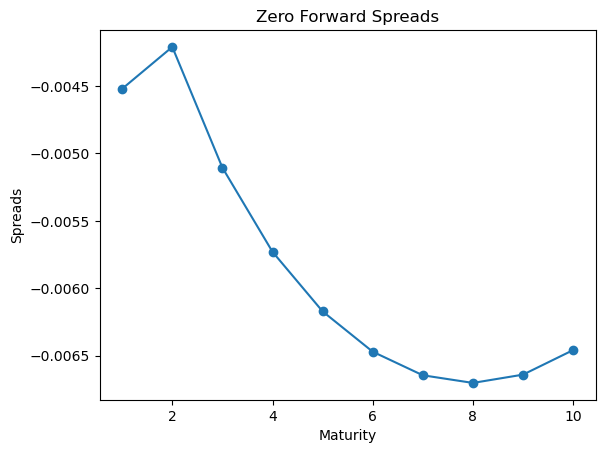

In [69]:
meanspreads = zero_forward_spreads.mean()
plt.plot(maturities[1:], meanspreads, marker='o')
plt.title('Zero Forward Spreads')
plt.xlabel('Maturity')
plt.ylabel('Spreads')

plt.show()